In [0]:
%%shell
sudo add-apt-repository ppa:ubuntugis/ppa && sudo apt-get update -y
sudo apt-get update -y
pip install --upgrade geopandas

 Official stable UbuntuGIS packages.


 More info: https://launchpad.net/~ubuntugis/+archive/ubuntu/ppa
Press [ENTER] to continue or Ctrl-c to cancel adding it.

Ign:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:2 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:6 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:7 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:9 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Get:10 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:11 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran35/ InRelease
Get:12 http://ppa.launchpad.net/marutter/c2d4u3.5/ubuntu bionic InRelease [15.4 kB]
Hit:13

In [0]:
from google.colab import files
import pandas as pd
import geopandas as gpd
from geopandas import GeoDataFrame
from shapely.geometry import Point, MultiPoint
from shapely.ops import nearest_points
import io
from random import randint, randrange
from xml.etree.ElementTree import Element, SubElement, Comment, tostring 
import xml.dom.minidom
import sys

In [0]:
uploaded = files.upload()

Saving 10000-locations.csv to 10000-locations (1).csv


In [0]:
#GLOBAL VARIABLES
NUM_DEPOTS = 1
LOCATIONS = 20
RADIUS = 500
NUM_VEHICLES = 5
CAPACITY = 100
BUCKET_SIZE = LOCATIONS
CUSTOMERS = LOCATIONS
DEPOT_LATITUDE = 33613.1588
DEPOT_LONGITUDE = -86118.3061
SOURCE_FILE_NAME = '10000-locations.csv'
OUTPUT_FILE = 'cvrp-customers.xml'

Depot: POINT (33613.1588 -86118.3061)


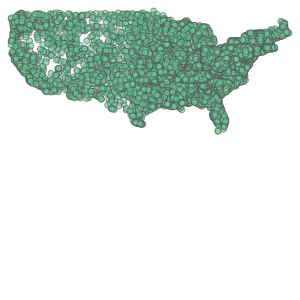

In [0]:
#Draw the 10k Locations
df = pd.read_csv(io.BytesIO(uploaded[SOURCE_FILE_NAME]), skiprows=[1])
df.set_index("id", inplace = True)
depot = Point(DEPOT_LATITUDE, DEPOT_LONGITUDE)
locations = MultiPoint([Point(xy) for xy in zip(df.longitude, df.latitude)])
print("Depot: " + str(depot))
depot
locations

/usr/local/lib/python3.6/dist-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


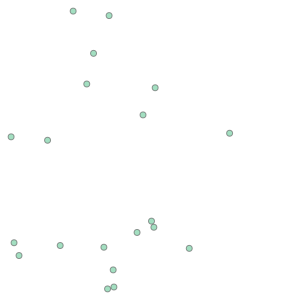

In [0]:
#Find locations within boundary, then output based on BUCKET_SIZE
def create_gdf(df, x="latitude", y="longitude"):
    gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df[x], df[y]), crs={"init":"EPSG:4326"})
    return gdf

gdf = create_gdf(df)
dis_calc = gdf.distance(depot).le(RADIUS)
boundary_series = dis_calc[dis_calc].index.tolist()
output_id_and_geo = gdf.loc[boundary_series, 'geometry']
if output_id_and_geo.size > BUCKET_SIZE:
  output_id_and_geo = output_id_and_geo.sample(n=BUCKET_SIZE, random_state=randint(0, 2**32 - 1))
MultiPoint([x for x in output_id_and_geo.geometry])

In [0]:
#Output to xml (formating and beautify)
counter_vrpairlocation_id = 1
counter_vrpdepot_id = 1
counter_main_id = 3
counter_id_customer = 2
counter_depot_reference = 3
depot_id_static = 0

top = Element ('VrpVehicleRoutingSolution', attrib={'id': str(1)})
child1_id = SubElement (top, 'id')
child1_id.text = str(0)
child2_name = SubElement(top, 'name')
child2_name.text = 'A-n33-k6'
child3_dt = SubElement(top, 'distanceType')
child3_dt.text = 'AIR_DISTANCE'
child4_dOM = SubElement(top, 'distanceUnitOfMeasurement')
child4_dOM.text = 'distance'

ll = SubElement(top, 'locationList', attrib={'id': str(2)})
val = SubElement(ll, 'VrpAirLocation', attrib={'id': str(counter_main_id)})
id = SubElement(val, 'id')
id.text = str(counter_vrpairlocation_id)
la = SubElement(val, 'latitude')
la.text = str(DEPOT_LATITUDE)
lo = SubElement(val, 'longitude')
lo.text = str(DEPOT_LONGITUDE)
counter_vrpairlocation_id, counter_main_id = counter_vrpairlocation_id+1, counter_main_id+1

def vrpAirLocation(row):
  global counter_vrpairlocation_id, counter_main_id
  val = SubElement(ll, 'VrpAirLocation', attrib={'id': str(counter_main_id)})
  id = SubElement(val, 'id')
  id.text = str(counter_vrpairlocation_id)
  la = SubElement(val, 'latitude')
  lo = SubElement(val, 'longitude')
  counter_vrpairlocation_id, counter_main_id = counter_vrpairlocation_id+1, counter_main_id+1

  for field in row.index:
    if field == 'latitude':
      la.text = '{0}'.format(row[field])
    elif field == 'longitude':
      lo.text = '{0}'.format(row[field])
  return tostring(val).decode('utf-8')

gdf.loc[output_id_and_geo.index,:].apply(vrpAirLocation, axis=1)

child7_dL = SubElement(top, 'depotList', attrib={'id': str(counter_main_id)})
counter_main_id += 1
grand_child7_dL = SubElement(child7_dL, 'VrpDepot', attrib={'id': str(counter_main_id)})
depot_id_static = counter_main_id
counter_main_id += 1
ggrand_child7_id = SubElement(grand_child7_dL, 'id')
ggrand_child7_id.text = str(counter_vrpdepot_id)
counter_vrpdepot_id += 1
ggrand_child7_lc = SubElement(grand_child7_dL, 'location', attrib={'class': "VrpAirLocation", 'reference': str(counter_depot_reference)})
counter_depot_reference += 1

vl = SubElement(top, 'vehicleList', attrib={'id': str(counter_main_id)})
counter_main_id += 1
for x in range(0, NUM_VEHICLES):
  vv = SubElement(vl, 'VrpVehicle', attrib={'id': str(counter_main_id)})
  counter_main_id += 1
  id = SubElement(vv, 'id')
  id.text = str(x)
  c = SubElement(vv, 'capacity')
  c.text = str(CAPACITY)
  dr = SubElement(vv, 'depot', attrib={'reference': str(depot_id_static)})

cl = SubElement(top, 'customerList', attrib={'id': str(counter_main_id)})
counter_main_id += 1
for x in range(0, CUSTOMERS):
  vc = SubElement(cl, 'VrpCustomer', attrib={'id': str(counter_main_id)})
  counter_main_id += 1
  id = SubElement(vc, 'id')
  id.text = str(counter_id_customer)
  counter_id_customer += 1
  l = SubElement(vc, 'location', attrib={'class': "VrpAirLocation", 'reference': str(counter_depot_reference)})
  counter_depot_reference += 1
  d = SubElement(vc, 'demand')
  d.text = str(randrange(CAPACITY))

f = open(OUTPUT_FILE, "w")
dom = xml.dom.minidom.parseString(tostring(top).decode('utf-8'))
pretty_xml_as_string = dom.toprettyxml()
f.write(pretty_xml_as_string)
f.close()